# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from fredapi import Fred


pd.set_option("display.precision", 2)

In [153]:
fred_key = '17193bb5d3d0af2508e249e344961fcf'
fred = Fred(api_key=fred_key)

In [154]:
def get_fred_data(code):
    return fred.get_series(code, frequency = 'm')

fred_codes = {'CPI' : 'CPIAUCSL',
              'Nominal_Price' : 'GASREGW'}

gasoline = pd.DataFrame()

for var in fred_codes.keys():
    gasoline[var] = get_fred_data(fred_codes[var])

In [155]:
gasoline['Time'] = pd.to_datetime(gasoline.index)
gasoline = gasoline.query("Time >= '1990-11-01'")
gasoline.head()

,CPI,Nominal_Price,Time
1990-11-01,133.7,1.32,1990-11-01
1990-12-01,134.2,1.34,1990-12-01
1991-01-01,134.7,1.18,1991-01-01
1991-02-01,134.8,1.09,1991-02-01
1991-03-01,134.8,1.04,1991-03-01


# 1) create the real price of gasoline

In [156]:
gasoline['Real_Price'] = (gasoline['Nominal_Price']/gasoline['CPI'])*100
gasoline.head(5)

,CPI,Nominal_Price,Time,Real_Price
1990-11-01,133.7,1.32,1990-11-01,0.99
1990-12-01,134.2,1.34,1990-12-01,1.00
1991-01-01,134.7,1.18,1991-01-01,0.88
1991-02-01,134.8,1.09,1991-02-01,0.81
1991-03-01,134.8,1.04,1991-03-01,0.77


## 2)  Plot real and nominal prices over time.

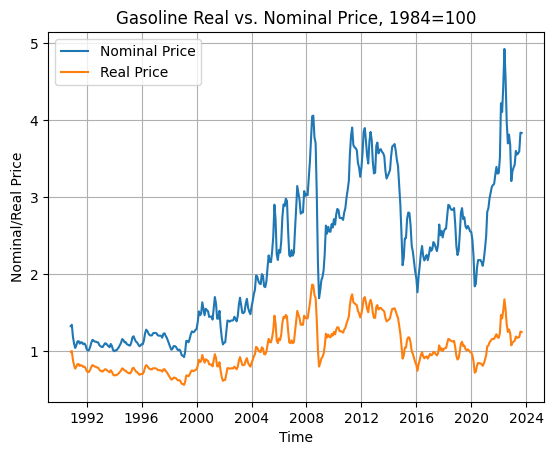

In [157]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'], label = 'Nominal Price')
plt.plot(gasoline['Time'], gasoline['Real_Price'], label='Real Price')

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.legend()
plt.grid()

Alternatively, plot them separately. Be aware of the different y-axis!

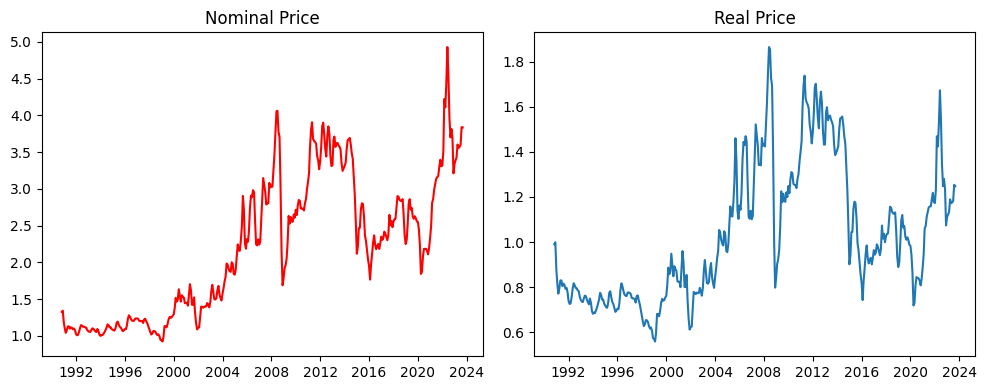

In [158]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(gasoline['Time'], gasoline['Nominal_Price'], color='red')
ax[0].set_title('Nominal Price')

ax[1].plot(gasoline['Time'], gasoline['Real_Price'])
ax[1].set_title('Real Price')

plt.tight_layout()
plt.show()

## 3) Consider the sample from obs 1 to Dec 2014. Plot the sample ACF of $y_{t}$ and $\Delta{y_t} = y_{t} - y_{t-1}$


In [159]:
# filter the data as requested
train = gasoline.query(" Time <= '2014-12-01' ")
test = gasoline.query(" Time > '2014-12-01' ")

# convert the data from float to numeric...
train['Real_Price'] = pd.to_numeric(train['Real_Price'], errors='coerce')

# ... otherwise we couldn't apply the .log() function
train['Log_Real_Price'] = np.log(train['Real_Price'])

# create the column delta for the first difference of the log price
train['Delta_Log'] = (train['Log_Real_Price']-train['Log_Real_Price'].shift(1))

# fill the first value with 0, otherwise the next code chunk won't produce an accurate ACF
train['Delta_Log'].fillna(0, inplace=True)

train.tail()

C:\Users\giord\AppData\Local\Temp\ipykernel_40188\140007827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Real_Price'] = pd.to_numeric(train['Real_Price'], errors='coerce')
C:\Users\giord\AppData\Local\Temp\ipykernel_40188\140007827.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Log_Real_Price'] = np.log(train['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_40188\140007827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,CPI,Nominal_Price,Time,Real_Price,Log_Real_Price,Delta_Log
2014-08-01,237.46,3.49,2014-08-01,1.47,0.38,-0.03
2014-09-01,237.48,3.41,2014-09-01,1.43,0.36,-0.02
2014-10-01,237.43,3.17,2014-10-01,1.34,0.29,-0.07
2014-11-01,236.98,2.91,2014-11-01,1.23,0.21,-0.08
2014-12-01,236.25,2.54,2014-12-01,1.08,0.07,-0.13


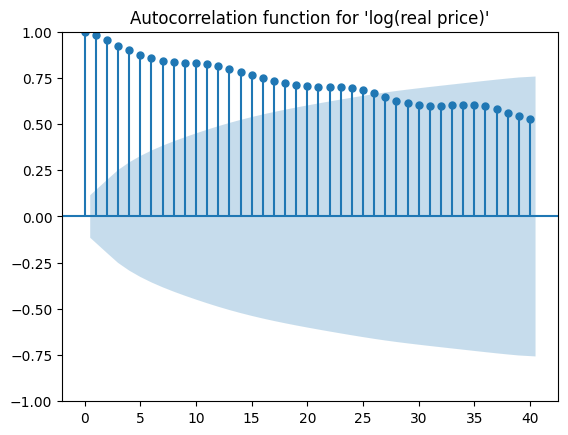

In [160]:
plot_acf(train['Log_Real_Price'], 
         lags=40,
         title="Autocorrelation function for 'log(real price)'");

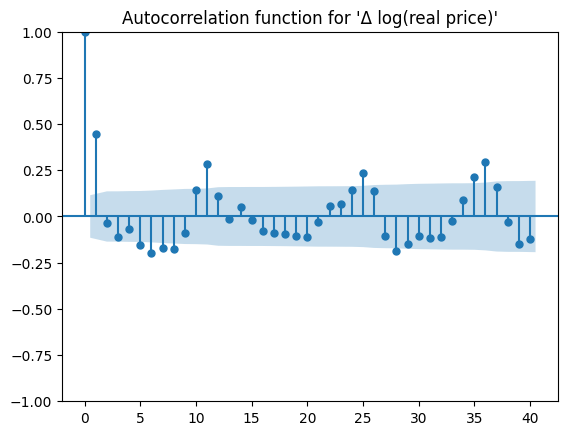

In [161]:
plot_acf(train['Delta_Log'], 
         lags=40, 
         title="Autocorrelation function for 'Δ log(real price)'");

## 4) Using the same sample above fit two AR(1) models: the first for $y_{t}$ and the second for Δ$y_{t}$. Report in both cases the coefficient associated with the lagged dependent variable.


In [162]:
# If the pvalue is above a critical size, then we cannot reject the null hypothesis that there is a unit root.

stationarity_test = adfuller(train['Log_Real_Price'], autolag='AIC')
stationarity_test

(-1.1021096314964258,
 0.7142298756294339,
 15,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 -900.0168558851688)

Since the ADF statistic, -1.10, is > than t-values at (1%,5%,10%), the null hypothesis **CANNOT** be rejected, where the null hypothesis is that there exists a unit root. If there exists a unit root, then the process is **NON**-stationary.


In my case, the ADF statistic is greater than the critical values. This suggests that the null hypothesis of a unit root is not rejected, indicating that the time series might indeed be NON-stationary (= it has relation with time).

Moreover, the p-value (0.71) exceed the significance level of 0.01, 0.05, 0.1.

In [163]:
# ar_log_real_price = AutoReg(filtered_gasoline['Log_Real_Price'], lags=1).fit()
# print(ar_log_real_price.summary())

In [164]:
# ar_delta_log = AutoReg(filtered_gasoline['Delta_Log'], lags=1).fit()
# print(ar_delta_log.summary())

In [165]:
model1 = ARIMA(train['Log_Real_Price'], order=(1, 0, 0))
results1 = model1.fit()

# Print model summary to see estimated parameters
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Real_Price   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 427.665
Date:                Fri, 20 Oct 2023   AIC                           -849.331
Time:                        17:05:43   BIC                           -838.321
Sample:                    11-01-1990   HQIC                          -844.920
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0271      0.231     -0.117      0.907      -0.480       0.426
ar.L1          0.9845      0.011     88.841      0.000       0.963       1.006
sigma2         0.0030      0.000     20.508      0.0

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [166]:
stationarity_test2 = adfuller(train['Delta_Log'], autolag='AIC')
stationarity_test2

(-5.005037087112577,
 2.1689326404112755e-05,
 14,
 275,
 {'1%': -3.454355055831705,
  '5%': -2.8721080938842976,
  '10%': -2.572401325619835},
 -900.7166722177867)

In [167]:
model2 = ARIMA(train['Delta_Log'], order=(1, 0, 0))
results2 = model2.fit()

# Print model summary to see estimated parameters
print(results2.summary())

                               SARIMAX Results                                
Dep. Variable:              Delta_Log   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 461.077
Date:                Fri, 20 Oct 2023   AIC                           -916.154
Time:                        17:05:43   BIC                           -905.145
Sample:                    11-01-1990   HQIC                          -911.743
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.58e-05      0.006     -0.017      0.986      -0.011       0.011
ar.L1          0.4535      0.031     14.708      0.000       0.393       0.514
sigma2         0.0024      0.000     17.901      0.0

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 5) Produce a series of 1 step-ahead forecasts for yt. Use the following models: 
- random walk (no drift), 
- ARIMA(1,1,0), 
- ARIMA(0,1,1), 
- ARIMA(1,1,1).  
To produce forecasts start from the sample that ends in Dec 2014 and add 1 observation at the time (i.e. expanding/recursive scheme)

In [185]:
test['Log_Real_Price'] = np.log(test['Real_Price'])

# create the column delta for the first difference of the log price
test['Delta_Log'] = (test['Log_Real_Price']-test['Log_Real_Price'].shift(1))

# fill the first value with 0, otherwise the next code chunk won't produce an accurate ACF
test['Delta_Log'].fillna(0, inplace=True)


C:\Users\giord\AppData\Local\Temp\ipykernel_40188\1796521597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Log_Real_Price'] = np.log(test['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_40188\1796521597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Delta_Log'] = (test['Log_Real_Price']-test['Log_Real_Price'].shift(1))
C:\Users\giord\AppData\Local\Temp\ipykernel_40188\1796521597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [186]:
test

,CPI,Nominal_Price,Time,Real_Price,Log_Real_Price,Delta_Log
2015-01-01,234.75,2.12,2015-01-01,0.90,-0.10,0.00e+00
2015-02-01,235.34,2.22,2015-02-01,0.94,-0.06,4.36e-02
2015-03-01,235.98,2.46,2015-03-01,1.04,0.04,1.03e-01
2015-04-01,236.22,2.47,2015-04-01,1.05,0.04,9.85e-04
2015-05-01,237.00,2.72,2015-05-01,1.15,0.14,9.28e-02
...,...,...,...,...,...,...
2023-05-01,303.29,3.56,2023-05-01,1.17,0.16,-1.47e-02
2023-06-01,303.84,3.57,2023-06-01,1.18,0.16,2.69e-03
2023-07-01,304.35,3.60,2023-07-01,1.18,0.17,5.59e-03
2023-08-01,306.27,3.84,2023-08-01,1.25,0.23,5.91e-02


**Random Walk**

In [193]:
random_walk_forecasts = []

for t in range(0, len(test)):  
    model = ARIMA(test['Log_Real_Price'][:t], order=(0, 1, 0))
    results = model.fit()
    forecast = results.forecast(steps=1)
    random_walk_forecasts.append(forecast.iloc[0])

exp_rw_forecast = np.exp(random_walk_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1026: RuntimeWarning: invalid value enco

**ARIMA (1,1,0)**

In [203]:
arima_110_forecasts = []

for t in range(0, len(test)):  
    model = ARIMA(test['Log_Real_Price'][:t], order=(1, 1, 0))
    results = model.fit()
    forecast = results.forecast(steps=1)
    random_walk_forecasts.append(forecast.iloc[0])

exp_arima_110_forecasts = np.exp(arima_110_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations t

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

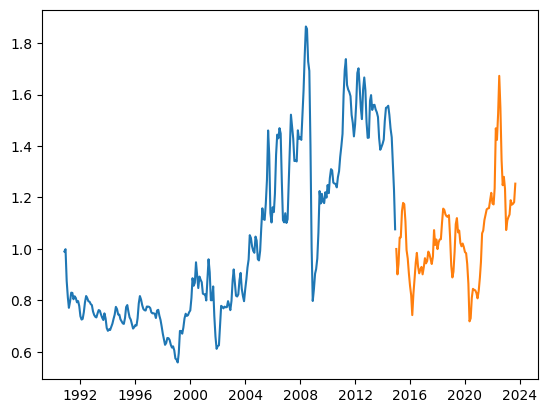

In [194]:
plt.plot(train['Time'], train['Real_Price'])
plt.plot(test['Time'], exp_rw_forecast)
plt.plot(test['Time'], exp_arima_110_forecasts)

In [192]:
len(exp_rw_forecast)

104